Привет! Меня зовут Валерий Гриднев, я провожу ревью твоей работы. Предлагаю общаться на «ты», если не против.

В работе ты увидишь комментарии, помеченные разным цветом.

<div class="alert alert-success">
Зеленым цветом помечены оброзцовые решения. Которые можно использовать в дальнейшем.
</div>

<div class="alert alert-warning">
Желтым цветом отмечено то, что ты можешь улучшить или доработать. Можешь учесть это при выполнении следующих работ или доработать проект сейчас, но это не обязательно.
</div>

<div class="alert alert-danger">
Красным цветом помечены моменты, которые необходимо доработать, чтобы проект был принят. Уверен, что у тебя все получится. Буду ждать твою работу на повторное ревью. 
</div>

Будет комфортнее работать над проектом вместе, если ты будешь **писать об изменениях** в проекте по моим рекомендациям. Для этого выбери для своих комментариев 

<div class="alert alert-block alert-info">заметный цвет</div>

Пожалуйста, **не перемещай, не изменяй и не удаляй мои комментарии**. Всё это поможет выполнить повторную проверку твоего проекта оперативнее.
___

<div class="alert alert-block alert-info">Валерий, привет! Исправления и комментарии - ниже по тексту</div>

<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Окей)
</div>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предварительная-подготовка" data-toc-modified-id="Предварительная-подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предварительная подготовка</a></span></li><li><span><a href="#Загрузка-и-анализ" data-toc-modified-id="Загрузка-и-анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и анализ</a></span></li><li><span><a href="#Обучение,-тестирование-и-проверка-адекватности" data-toc-modified-id="Обучение,-тестирование-и-проверка-адекватности-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение, тестирование и проверка адекватности</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Предварительная подготовка

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display_html
from itertools import chain,cycle
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import gc
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor
from warnings import filterwarnings
from sklearn.linear_model import Ridge
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import TimeSeriesSplit
filterwarnings("ignore")
pd.options.display.max_colwidth = 999

In [2]:
GLOBAL_RANDOM_STATE=12345

In [3]:
# общий класс для проведения исследований 
class Comparator:
    # переинициализация 
    def _reset(self):
        # перечень моделей и их гиперпараметров для перебора
        self.estimators = { 
            'DummyRegressor': {
                'estimator': DummyRegressor(),                                
                'grid': {
                    'strategy': ['mean'],
                },
            },  
            'Ridge': {
                'estimator': Ridge(),
                'grid': {
                    'alpha': np.linspace(0,2,10),
                    'max_iter': list(range(80,120,10)),
                    'fit_intercept': [True,False]                    
                }
            },                         
            'LinearRegression': {
                'estimator': LinearRegression(),
                'grid': {
                    'fit_intercept': [True, False],
                    'normalize': [True, False]
                },
            },
            'RandomForestRegressor': {
                'estimator': RandomForestRegressor(),
                'grid': {
                    'max_depth': [2, 3, 5],
                    'n_estimators': [11, 29, 43],
                    'random_state': [GLOBAL_RANDOM_STATE]                
                },
            },
            'LGBMRegressor': {
                'estimator': LGBMRegressor(),
                'grid': {
                    'n_estimators': [11, 29, 43],
                    'max_depth': [2, 3, 5],
                    'random_state': [GLOBAL_RANDOM_STATE]                
                }
            },   
            'CatBoostRegressor': {
                'estimator': CatBoostRegressor(),
                'grid': {
                    'verbose': [False],
                    'n_estimators': [11, 29, 43],
                    'learning_rate': [0.1, 0.5, 0.9],
                    'random_state': [GLOBAL_RANDOM_STATE]                
                }
            },   
        }
        
    # расчет качества: единая точка, чтобы можно было легко изменить по ходу работы
    @staticmethod
    def _error(targ, targ_pred):
        error = mean_squared_error(targ, targ_pred) ** 0.5 # rmse
        return error

    # сравнение алгоритмов
    def process(self, 
                    data: pd.DataFrame,
                    target: str,
                    feat_categorial: list,
                    feat_numeric: list,
                    test_share: float = 0.1,
                    cv: int = 3,
                    shuffle=False,
                    time_series_split=False,
                    activate: list = None) -> None:
        
        start_time = time.perf_counter()

        self._reset()
        
        targ = data[target]
        feat = data.drop(columns=[target]) 
        
        feat = self._encoding(feat, feat_categorial)

        feat_train, feat_test, targ_train, targ_test = self._train_test_split(feat, targ, test_share, shuffle)
        
        self.feat_train = feat_train
        self.feat_test = feat_test
        self.targ_train = targ_train
        self.targ_test = targ_test
        
        feat_train = feat_train.copy().reset_index(drop=True)
        feat_test = feat_test.copy().reset_index(drop=True)
        targ_train = targ_train.copy().reset_index(drop=True);
        targ_test = targ_test.copy().reset_index(drop=True);   
        
        feat_train_scaled, feat_test_scaled = self._scale(feat_train, feat_test, feat_numeric)

        self.feat_train = feat_train_scaled
        self.feat_test = feat_test_scaled
        
        for estimator_name in self.estimators:
            estimator = self.estimators[estimator_name]['estimator']
            if activate != None:
                if not estimator_name in activate:
                    continue
            self._gridsearch_wrapper(estimator,
                                     feat_train,
                                     targ_train,
                                     cv,
                                     time_series_split)

            self._predict_and_score(estimator, feat_train, targ_train, 'pred_train', 'pred_score_train','pred_time_train')
            self._predict_and_score(estimator, feat_test, targ_test, 'pred_test', 'pred_score_test','pred_time_test') 
            
        end_time = time.perf_counter()
        print('Общее время:', (end_time-start_time))
        
    def _train_test_split(self, feat: pd.DataFrame, targ: pd.Series, test_share=0.1, shuffle=False):
        return train_test_split(feat, targ, test_size=test_share, shuffle=shuffle, random_state=GLOBAL_RANDOM_STATE)        
        
    def _gridsearch_wrapper(self,
                            estimator,
                            feat_train: pd.DataFrame,
                            targ_train: pd.DataFrame,
                            cv,
                            time_series_split):
        xcv = TimeSeriesSplit(cv) if time_series_split else cv
        self._gridsearch(estimator, feat_train, targ_train, xcv)    
        
    # масштабирование
    def _scale(self, feat_train: pd.DataFrame, feat_valid: pd.DataFrame, feat_numeric: list) -> list:
        scaler = StandardScaler()
        scaler.fit(feat_train[feat_numeric])
        feat_train[feat_numeric] = scaler.transform(feat_train[feat_numeric])
        feat_valid[feat_numeric] = scaler.transform(feat_valid[feat_numeric])
        return [feat_train, feat_valid]        

    # ohe
    def _encoding(self, feat: pd.DataFrame, feat_categorial: list) -> list:
        feat = pd.get_dummies(feat, drop_first=True, columns=feat_categorial)
        return feat       
    
    
    # предсказания с лучшими параметрами и расчет метрики 
    def _predict_and_score(self,
                           estimator,
                           feat: pd.DataFrame, 
                           targ: pd.Series, 
                           pred_key: str, 
                           score_key: str,
                           pred_time_key: str) -> None:
            estimator_name = estimator.__class__.__name__
            start_time = time.perf_counter()
            pred = self.estimators[estimator_name]['best'].predict(feat)
            end_time = time.perf_counter()
            self.estimators[estimator_name][pred_key] = pd.Series(pred)
            self.estimators[estimator_name][score_key] = Comparator._error(targ, pred)
            self.estimators[estimator_name][pred_time_key] = round(end_time-start_time, 3)
            
        
    # подбор гиперпараметров и сохранение лучшей модели для каждого конкретного алгоритма
    def _gridsearch(self, estimator: object, feat: pd.DataFrame, targ: pd.Series, cv) -> None:
        start_time = time.perf_counter()
        estimator_name = estimator.__class__.__name__
        gscv = GridSearchCV(
                estimator,
                self.estimators[estimator_name]['grid'],
                scoring=make_scorer(Comparator._error, greater_is_better=False),
                cv=cv,
                verbose=0,
                return_train_score=True,
                refit=True,
                n_jobs=4
        )
        gscv.fit(feat, targ)
        end_time = time.perf_counter()
        timedelta = round(end_time-start_time,3)
        self.estimators[estimator_name]['params'] = gscv.best_params_
        self.estimators[estimator_name]['score'] = gscv.best_score_ * (-1)
        self.estimators[estimator_name]['best'] = gscv.best_estimator_
        self.estimators[estimator_name]['time_fit'] = timedelta
        print('Выбор гиперпараметров', estimator_name,'занял',"{:.3f}".format(timedelta), 'секунд')
            
    # сводный отчет о результатах
    def report(self):
        frame = pd.DataFrame(
            { 
                "Estimator": [], 
                "Лучшие параметры": [], 
                "CV-RMSE (train)": [],
                "RMSE (train)": [],
                "RMSE (test)": [],
                "Time (fit)": [],
                "Time (predict, train)": [],
                "Time (predict, test)": []
            })
        for estimator_name in self.estimators:
            if 'best' in self.estimators[estimator_name]:
                frame.loc[len(frame)] = [
                    estimator_name,
                    self.estimators[estimator_name]['params'], 
                    self.estimators[estimator_name]['score'], 
                    self.estimators[estimator_name]['pred_score_train'], 
                    self.estimators[estimator_name]['pred_score_test'], 
                    self.estimators[estimator_name]['time_fit'], 
                    self.estimators[estimator_name]['pred_time_train'], 
                    self.estimators[estimator_name]['pred_time_test']
                ]
        return frame
            
    def predictions(self, classname: str) -> list:
        for estimator in self.estimators:
            if estimator.__class__.__name__  == classname:
                result = {
                    'pred_train': self.estimators[estimator]['pred_train'], 
                    'pred_test': self.estimators[estimator]['pred_test'] 
                }
                return result
        return None
    
    # масштабированные feature_impotrances во всех best models
    def scaled_feature_importances(self, round_digits=3, sort_ascending=False) -> pd.DataFrame:
        scaled_feature_importances = pd.DataFrame(columns=self.feat_train.columns)
        for estimator_name in self.estimators:
            if 'best' not in self.estimators[estimator_name]:
                continue
            estimator = self.estimators[estimator_name]['best']
            if hasattr(estimator,'feature_importances_'):
                scaled_feature_importances.loc[estimator_name] = estimator.feature_importances_
        scaler = MinMaxScaler()
        transposed = scaled_feature_importances.transpose()
        transposed_scaled_feature_importances = pd.DataFrame(
                                                    scaler.fit_transform(transposed),
                                                    columns=transposed.columns, 
                                                    index=transposed.index)
        cols = list(transposed_scaled_feature_importances.columns.values)
        return transposed_scaled_feature_importances\
                .apply(lambda x: round(x, round_digits))\
                .sort_values(by=cols, ascending=sort_ascending)          

<div class="alert alert-danger">
    
**Комментарий ревьюера**
    
При работе с временными рядами мы не можем делать перекрестную проверку в стандартном виде)Пожалуйста поправь)
</div>

<div class="alert alert-block alert-info">Да, согласен. Скорректировал параметры, добавив опцию time_series_split, с соответствующим разбиением для CV</div>

<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Отлично)
</div>

<div class="alert alert-success">
    
**Комментарий ревьюера**
    
Круто конечно, что ты это всё реализовал)Но тебе не кажется, что это слишком сложно?)
</div>

<div class="alert alert-block alert-info">Честно говоря - нет. Это просто накопленные результаты предыдущих работ, они "делают свое дело" и пусть и продолждают в том же духе </div>

<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Накопления это хорошо)Но уже получается портянка, которая делает элементарные вещи)Решать конечно тебе, но я бы рекомендовал как минимум пересмотреть ее и уменьшить, убрав класс и сделав просто отдельные функции)
</div>

In [4]:
# построение графика-линии по одному и более серий
def line(series_name_x_y_dict, xlab='', ylab='', title='', figsize=(10,5), fontsize=12):
    plt.rcdefaults()
    plt.rcParams.update({'font.size': fontsize})
    fig, ax = plt.subplots()
    legend_list = []
    for name in series_name_x_y_dict:
        legend_list.append(name)
        ax.plot(
            series_name_x_y_dict[name]['x'],
            series_name_x_y_dict[name]['y'],
            linewidth=5
        )
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_title(title)        
    ax.legend(legend_list)
    fig.set_size_inches(figsize)
    fig.tight_layout()
    plt.show()

In [5]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:left"><td style="vertical-align:top">'
        html_str+=f'<h3>{title}</h3>'
        html_str+=df.to_html().replace('table','table style="display: inline; "')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [6]:
# вывод статистики с более информативной визуализацией
def frame_info(df, nans_bar=True): 
    frame = df\
    .isna()\
    .sum()\
    .to_frame(name='Nans')\
    .assign(Nans_share = lambda data: data['Nans'] / df.shape[0])\
    .join(df.count().rename('Non-Nans'), how='inner')\
    .assign(Type = df.dtypes)\
    .sort_values(by='Nans')\
    [['Non-Nans','Nans','Nans_share','Type']]
    return frame\
            .style\
            .bar(subset=['Nans_share'],color='lightblue') if nans_bar else frame

In [7]:
# barchart с горизонтальной раскладкой
def barchart(df: pd.DataFrame, xlabel='', ylabel='', title='', xrange=(0,1), yrange=None, figsize=(10,5), fontsize=12, grid_axis='x'):
    plt.rcdefaults()
    plt.rcParams.update({'font.size': fontsize})
    dft = df.transpose()

    size = len(dft.values)
    full_height = 1
    intercol_height = 0.1
    height = full_height / size 
    y = []
    for i in range(len(dft.columns), 0, -1):
        y.append(i * (full_height + intercol_height) + intercol_height)
    y = np.array(y)
    fig, ax = plt.subplots()
    for i in range(size):
        bar = ax.barh(y + i * height, dft.values[i], height, label=dft.index.values[i])
        # ax.bar_label(bar, padding=2) # только с версии 3.4 matplotlib

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_yticks(y - height/2 + size*height/2)
    ax.set_yticklabels(dft.columns)
    ax.legend()

    fig.set_size_inches(figsize)
    plt.grid(axis=grid_axis)    
    fig.tight_layout()
    plt.show()

<div class="alert alert-success">
    
**Комментарий ревьюера**
    
Посмотрим как всё это работает)Ощущения непонятные)С одной стороны это всё красиво и удобно, но с другой, это написать сложнее в 2 раза чем сам проект
</div>

## Загрузка и анализ

In [8]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

<div class="alert alert-danger">
    
**Комментарий ревьюера**
    
Нам нужна сумма заказов за час, а не среднее(
</div>

<div class="alert alert-block alert-info">Да, тут что-то я проморгал. Не удивительно, что итоговый результат у меня был сразу ниже обозначенного лимита в 48. Поправил</div>

<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Бывает)
</div>

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [10]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


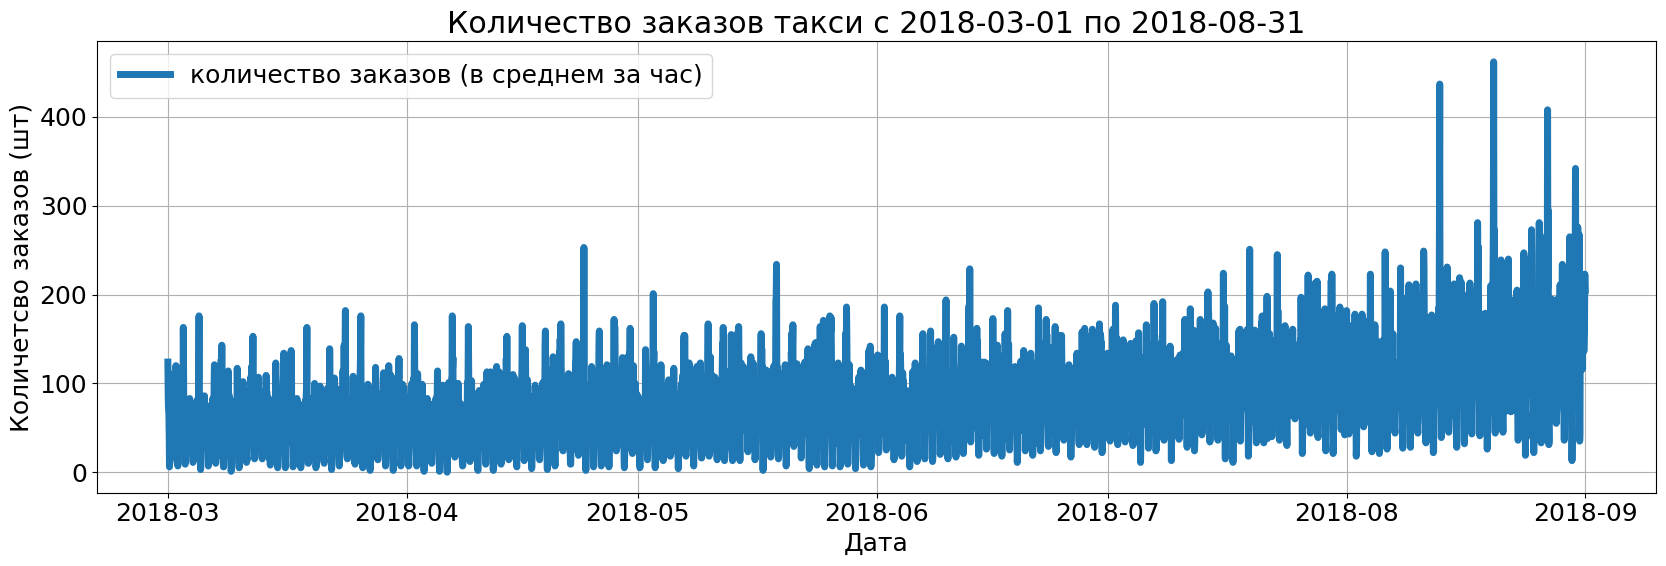

In [11]:
series_name_x_y_dict = {}
series_name_x_y_dict['количество заказов (в среднем за час)']  = {
                'x': pd.Series(data.index),
                'y': data['num_orders'],
             }   
line(
    series_name_x_y_dict, 
    xlab='Дата',
    ylab='Количетсво заказов (шт)', 
    title='Количество заказов такси c 2018-03-01 по 2018-08-31', 
    figsize=(17,6), 
    fontsize=18)

In [12]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Декомпозируем:

In [13]:
decomposed = seasonal_decompose(data)

Тренд? Смело можно еще раз разложить на компоненты, но в целом - восходящий (рост популярности сервиса?)

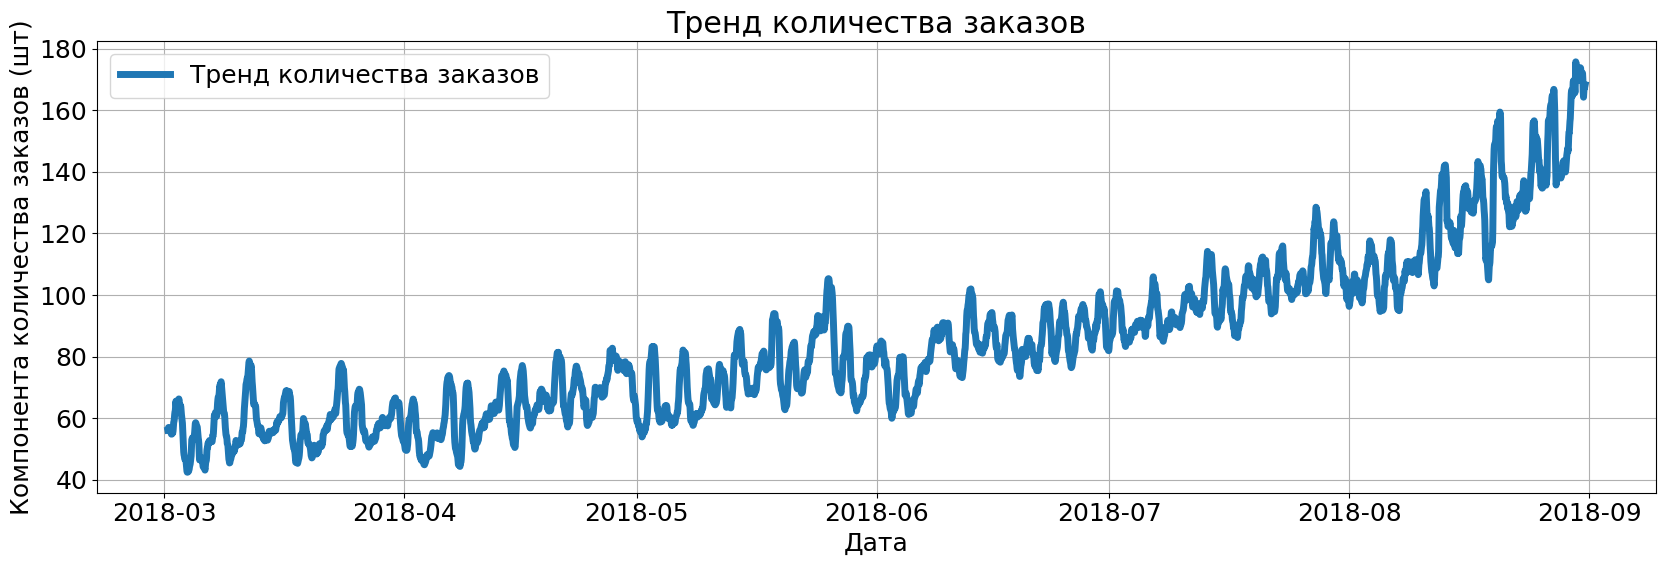

In [14]:
series_name_x_y_dict = {}
series_name_x_y_dict['Тренд количества заказов']  = {
                'x': pd.Series(decomposed.trend.index),
                'y': decomposed.trend,
             }   
line(
    series_name_x_y_dict, 
    xlab='Дата',
    ylab='Компонента количества заказов (шт)', 
    title='Тренд количества заказов', 
    figsize=(17,6), 
    fontsize=18)

Сезонность? По времени суток: 

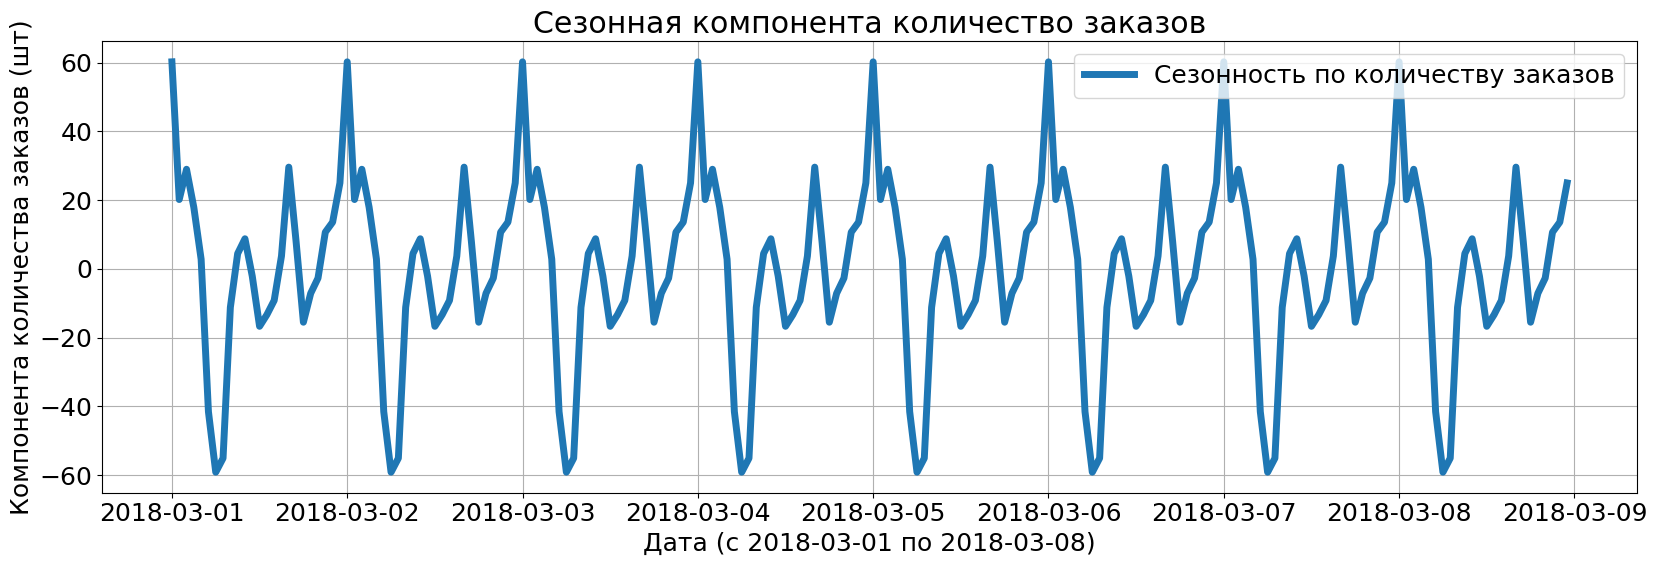

In [15]:
series_name_x_y_dict = {}
series_name_x_y_dict['Сезонность по количеству заказов']  = {
                'x': pd.Series(decomposed.seasonal['2018-03-01':'2018-03-08'].index),
                'y': decomposed.seasonal['2018-03-01':'2018-03-08'],
             }   
line(
    series_name_x_y_dict, 
    xlab='Дата (c 2018-03-01 по 2018-03-08)',
    ylab='Компонента количества заказов (шт)', 
    title='Сезонная компонента количество заказов', 
    figsize=(17,6), 
    fontsize=18)

<div class="alert alert-block alert-info">После смены mean() на sum() для улучшения результатов "сезонность" используется в признаках, чтобы максимально приблизить "суточный" кусок схожей функцией, особенно с учетом его влияния на результат в абсолютных значениях</div>

<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Отлично)Хорошее решение)
</div>

Остатки? С такими значениями также можно еще поработать:

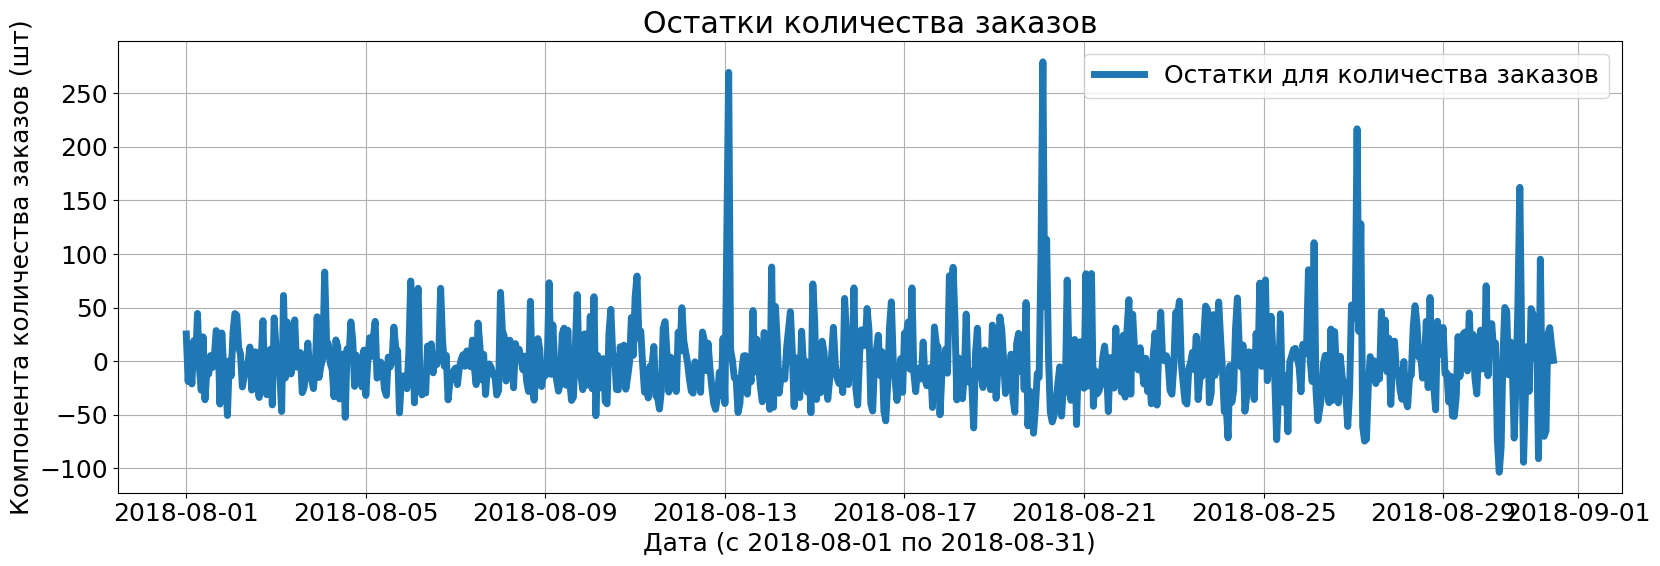

In [16]:
series_name_x_y_dict = {}
series_name_x_y_dict['Остатки для количества заказов']  = {
                'x': pd.Series(decomposed.resid['2018-08-01':'2018-08-31'].index),
                'y': decomposed.resid['2018-08-01':'2018-08-31'],
             }   
line(
    series_name_x_y_dict, 
    xlab='Дата (c 2018-08-01 по 2018-08-31)',
    ylab='Компонента количества заказов (шт)', 
    title='Остатки количества заказов', 
    figsize=(17,6), 
    fontsize=18)

## Обучение, тестирование и проверка адекватности

Подготовим признаки:

In [17]:
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
# несколько лагов
for lag in range(1, 5):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
# подобрано по результатам переборов и пост-анализа feature_importances_
for rms in [8,12,24]:
    data['rolling_mean_{}'.format(rms)] = data['num_orders'].shift().rolling(rms).mean()
data.dropna(inplace=True)
# попытаемся сформировать признаки, помогающие отразить цикличность
x = 2 * np.pi * data.index.hour / 24
data['a'] = -1 * np.cos(x) ** 3 + 4 * np.cos(2 * x)
data['b'] = np.cos(2 * x)  + np.cos(x / 3) ** 2
data['c'] = 2 * np.cos(x + np.pi/3) - np.cos(2 * x + np.pi/12) ** 2  - np.cos(x) ** 3
# разделим на категориальные и численные
target = 'num_orders'
feat=list(data.columns)
feat.remove(target)
feat_categorial = ['month','day','dayofweek']
feat_numeric = list(set(feat) - set(feat_categorial))
display_side_by_side(
    frame_info(data[feat_categorial], nans_bar=False).sort_index(),
    frame_info(data[feat_numeric], nans_bar=False).sort_index(),
    titles=['Категориальные', 'Численные']
    
)

,Non-Nans,Nans,Nans_share,Type
day,4392,0,0.0,int64
dayofweek,4392,0,0.0,int64
month,4392,0,0.0,int64
,Non-Nans,Nans,Nans_share,Type
a,4392,0,0.0,float64
b,4392,0,0.0,float64
c,4392,0,0.0,float64
lag_1,4392,0,0.0,float64
lag_2,4392,0,0.0,float64
lag_3,4392,0,0.0,float64


Обучим и сравним модели:

In [18]:
comparator = Comparator()
comparator.process(
                    data, 
                    'num_orders', 
                    feat_categorial, 
                    feat_numeric, test_share=0.1, 
                    shuffle=False, 
                    cv=30, 
                    time_series_split=True)
report = comparator.report()
report.sort_values(by='RMSE (test)')

Выбор гиперпараметров DummyRegressor занял 5.383 секунд
Выбор гиперпараметров Ridge занял 37.592 секунд
Выбор гиперпараметров LinearRegression занял 2.498 секунд
Выбор гиперпараметров RandomForestRegressor занял 53.717 секунд
Выбор гиперпараметров LGBMRegressor занял 28.165 секунд
Выбор гиперпараметров CatBoostRegressor занял 355.524 секунд
Общее время: 483.27181125059724


,Estimator,Лучшие параметры,CV-RMSE (train),RMSE (train),RMSE (test),Time (fit),"Time (predict, train)","Time (predict, test)"
4,LGBMRegressor,"{'max_depth': 5, 'n_estimators': 43, 'random_state': 12345}",2.297968e+01,19.886915,41.515248,28.165,0.093,0.014
5,CatBoostRegressor,"{'learning_rate': 0.1, 'n_estimators': 43, 'random_state': 12345, 'verbose': False}",2.350016e+01,22.336252,46.526875,355.524,0.006,0.005
1,Ridge,"{'alpha': 2.0, 'fit_intercept': True, 'max_iter': 80}",2.745526e+01,26.401898,48.268958,37.592,0.003,0.092
3,RandomForestRegressor,"{'max_depth': 5, 'n_estimators': 43, 'random_state': 12345}",2.495169e+01,23.587700,48.796787,53.717,0.013,0.007
2,LinearRegression,"{'fit_intercept': False, 'normalize': True}",1.186954e+12,27.322798,55.032125,2.498,0.005,0.090
0,DummyRegressor,{'strategy': 'mean'},3.814805e+01,38.705413,84.687683,5.383,0.001,0.000


Дополнительный интерес представляет разве что визуальное попарное сравнение Топ-3 моделей с реальными данными:

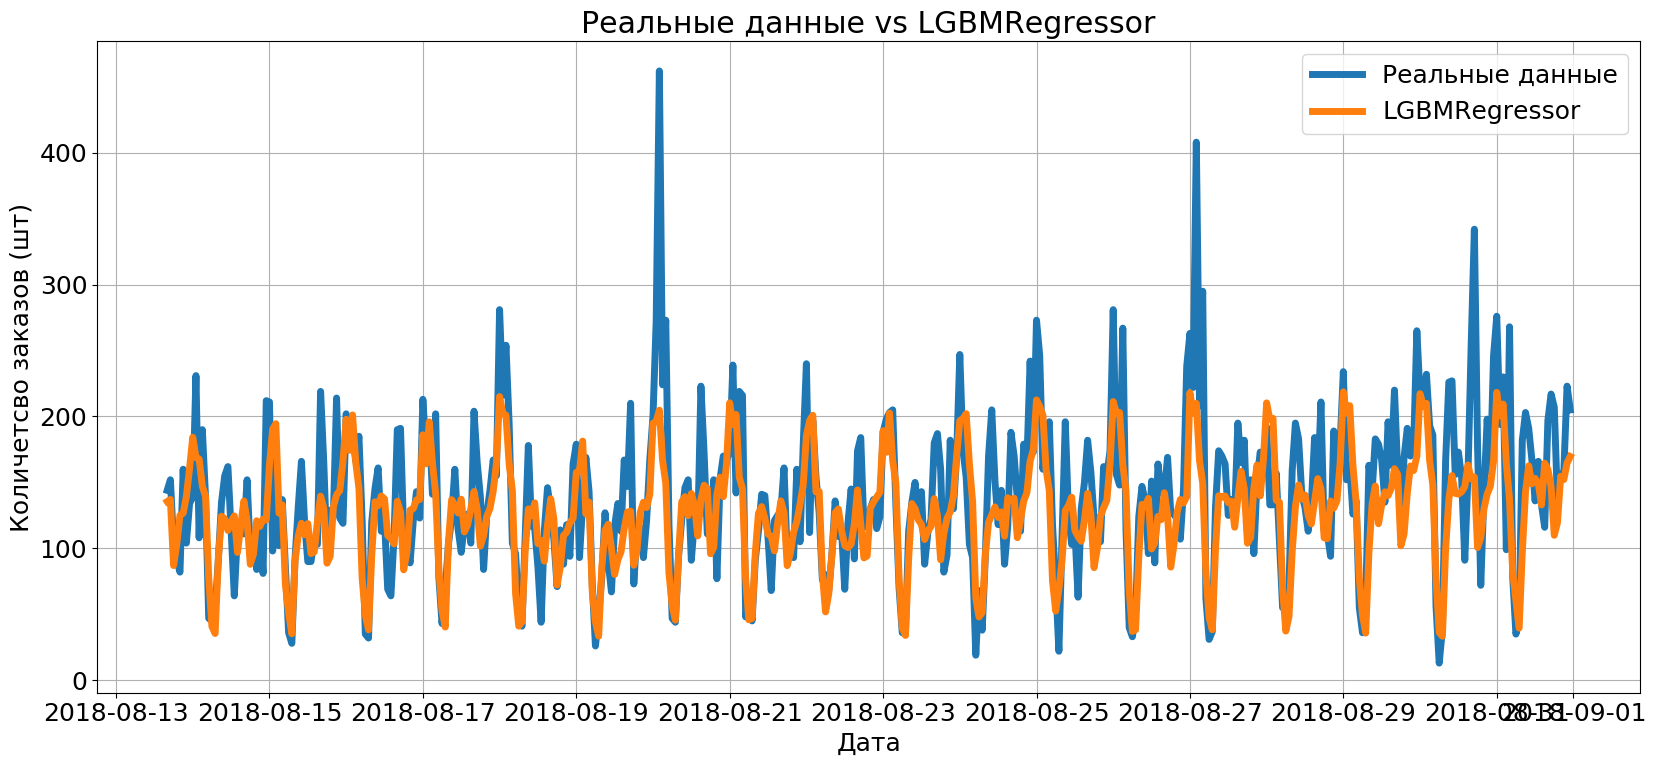

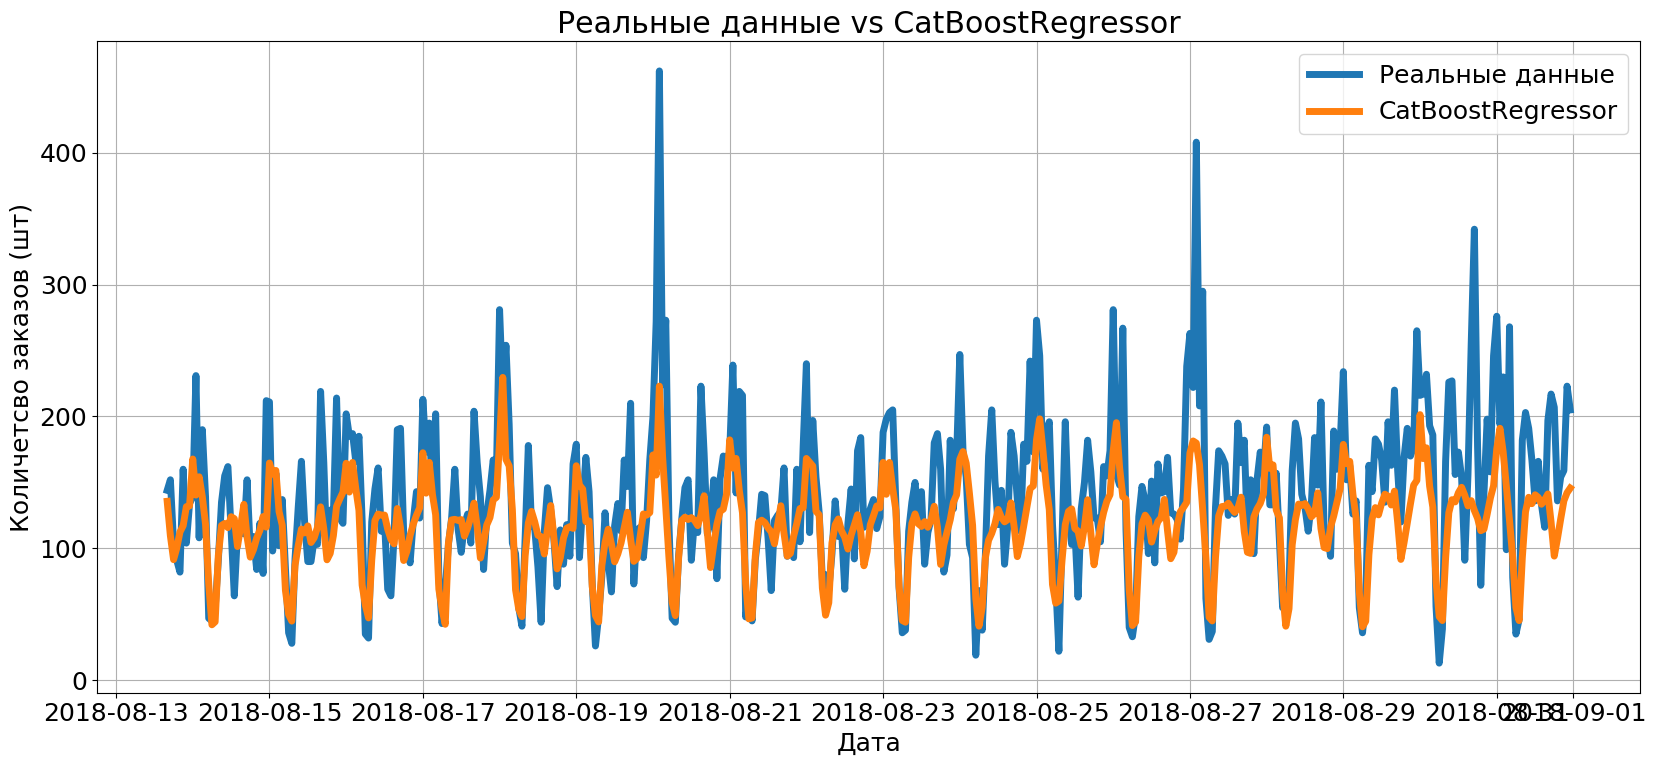

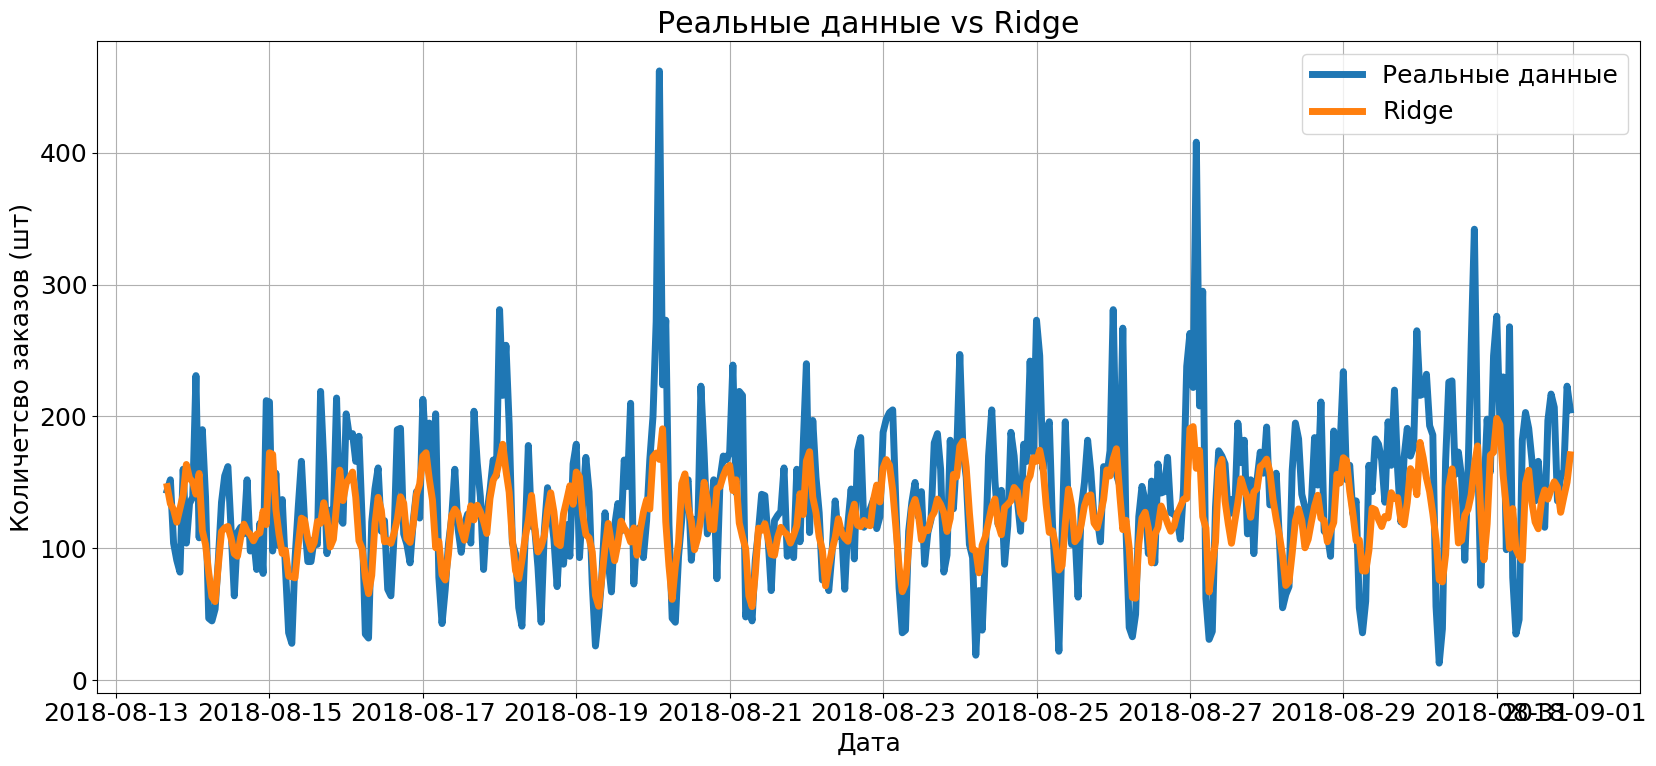

In [19]:
top = 3
for estimator in list(report.sort_values(by="RMSE (test)")['Estimator'].values[:top]):
    series_name_x_y_dict = {}
    series_name_x_y_dict['Реальные данные'] = {
                'x': pd.Series(comparator.targ_test.index),
                'y': comparator.targ_test,        
    }
    series_name_x_y_dict[estimator] = {
                'x': pd.Series(comparator.targ_test.index),
                'y': comparator.estimators[estimator]['pred_test'],
    }   
    line(
        series_name_x_y_dict, 
        xlab='Дата',
        ylab='Количетсво заказов (шт)', 
        title='Реальные данные vs {}'.format(estimator), 
        figsize=(17,8), 
        fontsize=18)

Здесь наверное следует сказать что-то вроде "все стараются, но даже лидеры не очень хороши". Есть над чем еще поработать.

В завершении, посмотрим на Топ-10 признаков (для тех алгоримтов, где подобные данные доступны):

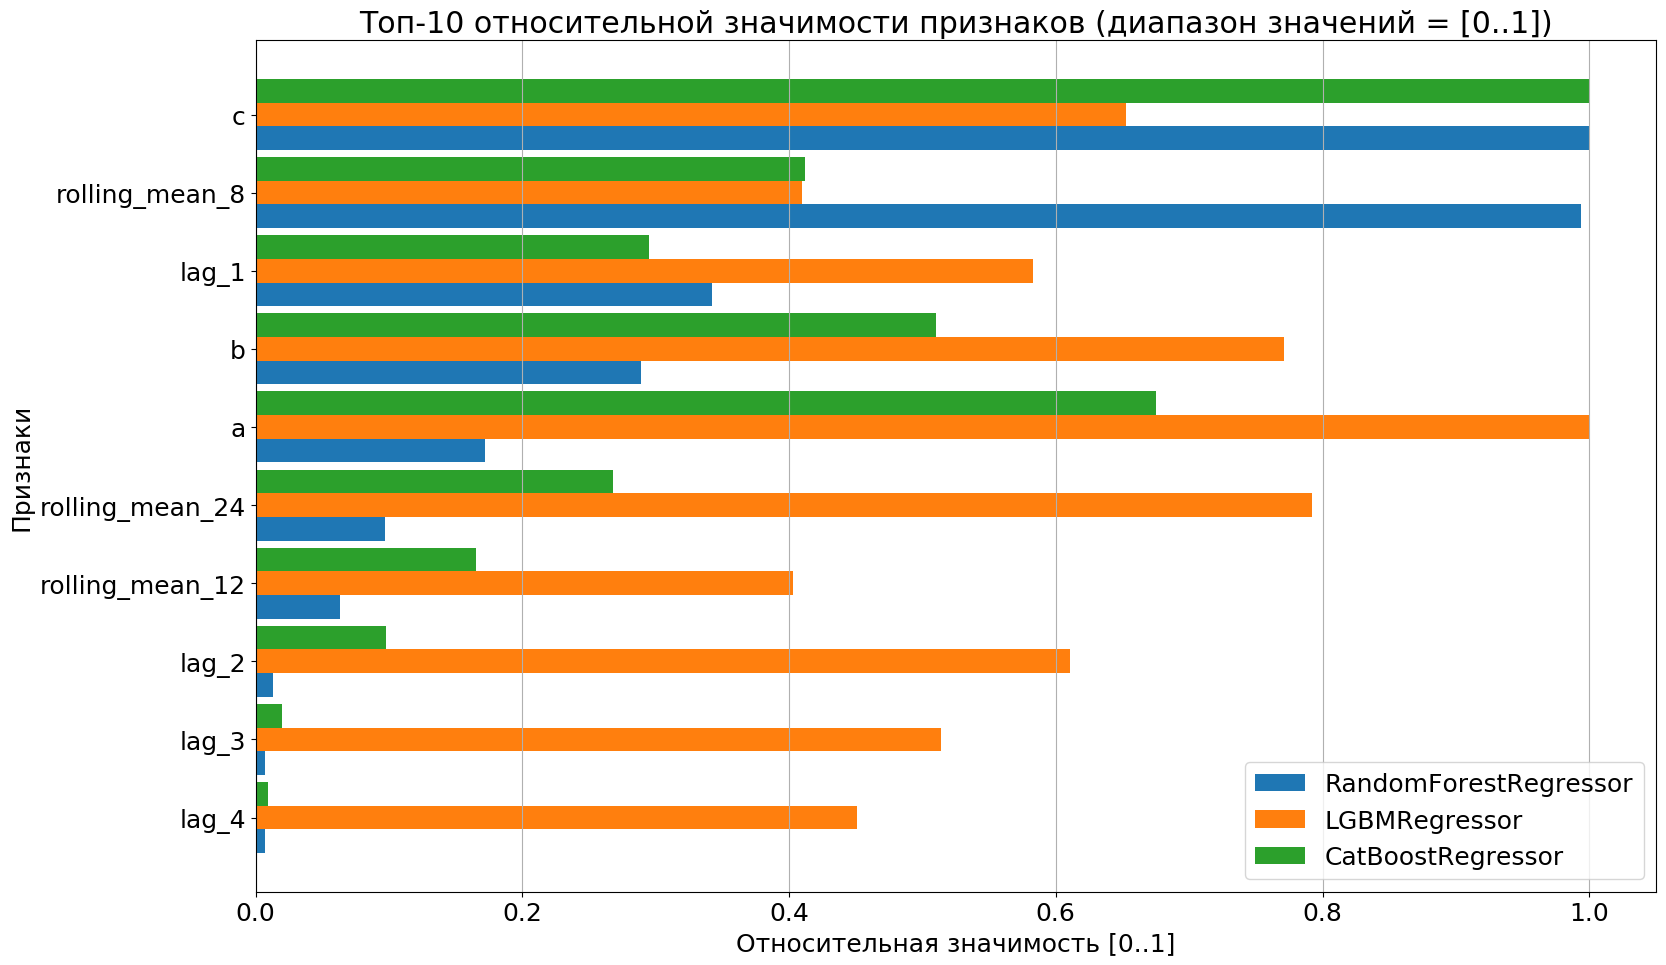

In [20]:
scaled_feature_imporances = comparator.scaled_feature_importances()
barchart(
    scaled_feature_imporances.head(10),
    ylabel='Признаки',
    xlabel='Относительная значимость [0..1]',
    title='Топ-10 относительной значимости признаков (диапазон значений = [0..1])',
    figsize=(17,10), 
    fontsize=18)

<div class="alert alert-block alert-info">Значимы "максимально приближающие суточный вклад признаки" и именно они позволяют преодолеть порог в 48. Можно подобрать несоклько "идеальныых аппроксимаций суточных колебаний" (и вероятно, <b>попытаться</b> сделать то же самое для остатков), но распознавание картинок на wolframalpha - платное, а "ручной подбор" занимает время. </div>



<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Для вводного проекта этого хватит с головой, молодец)
</div>

<div class="alert alert-success">
    
**Комментарий ревьюера**
    
Георгий, очень понравилась твоя визуализация и подход к решению, молодец)Пожалуйста исправь 2 моих замечания, после этого я посмотрю еще раз, т.к. результаты конечно сильно изменятся)
    
Есть несколько вопросов:
    
1)В тз ведь есть rmse 48, не смутило, что получилось так мало?
    
2)Берешь большие числа для rolling_mean, с чем это связано? И почему именно такие?)
    
Если есть какие-то вопросы, буду рад ответить на них)
    
P.S. На мой взгляд стоит чуть-чуть добавить рассуждений и выводов по ходу решения)
</div>

<div class="alert alert-block alert-info">
1) Естественно, смутило. Но почему-то простая мысль "при аггрегации нужна сумма, а не среднее" в голову не пришла. Что-то вроде "глаз замылился" - "смотрю, но не вижу"

2) Убрал. Они в итоге только ухудшают целевую метрику (хотя тренд и был явно выражен)

В целом, итоговый вывод: для временных рядов надо делать feature engeneering по компонентам ряда в том числе, аппроксимируя их значения известными функциями, фактически - "подсказывая" алгоритму. 
    
P.S. Если ты сходу готов предложить признаки, которые качественно смогут улучшить результат - поделись опытом, или подставь самостоятельно и запусти - посмотрим вместе на итоги.
</div>


<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
1-2 ок)
    
3)Да, главное не допустить лик)
    
4)Здесь можно добиться лучшего, но на мой взгляд это не так значительно. Чтобы это получилось, опять же посмотреть на все наши признаки, где-то добавить, где-то попробовать сгенерировать)
    
Спасибо за ответы и за качественную работу, проект принимаю)В качестве допа хочу предложить материалы по cv, которые могут пригодиться в будущем)
    
https://habr.com/ru/company/mipt/blog/450732/
    
https://www.youtube.com/channel/UCQj_dwbIydi588xrfjWSL5g
    
https://habr.com/ru/company/smartengines/blog/499566/
</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48